# Extract Safran Data


In [1]:
# Magic
%load_ext autoreload
%autoreload 2

# Imports

from tqdm import tqdm

import netCDF4 as nc
import rasterio
import xarray as xr

import pandas as pd
import glob
import numpy as np
import os
import folium
import matplotlib.pyplot as plt
import chime
import datetime as datetime
from datetime import datetime

chime.theme("mario")

# Import Functions
import sys

sys.path.insert(0, "../../src")
from run_mp import *
from utilities import *
from gee_data_wrangling import *

# 👉 User Input


In [2]:
# Give list of ncfiles
ffolder = "../../data/raw/safran/"
ffolder = glob.glob(ffolder + "*.nc")

# Remove path from folder
ffolder_noprefix = sorted([os.path.basename(x) for x in ffolder])

print("Datasets available for extraction:")
for i, f in enumerate(ffolder):
    print(f" {i+1}.\t{f}")

Datasets available for extraction:
 1.	../../data/raw/safran/ORCHIDEE_France-8km-1hour_2000_fromSAFRAN.nc
 2.	../../data/raw/safran/ORCHIDEE_France-8km-1hour_2001_fromSAFRAN.nc
 3.	../../data/raw/safran/ORCHIDEE_France-8km-1hour_2002_fromSAFRAN.nc


# Test Function to Access NC file


280.3518981933594

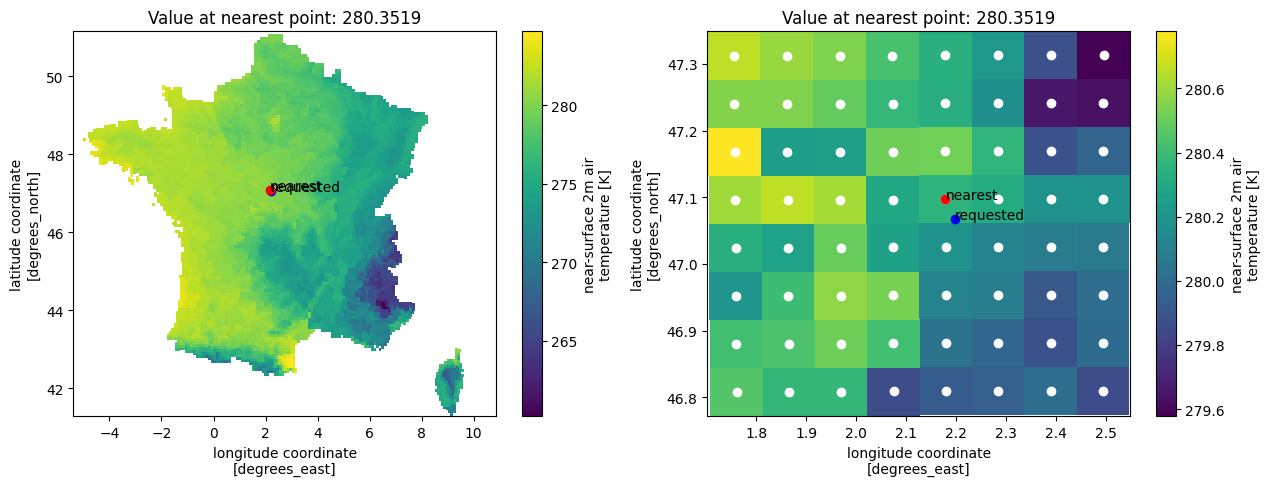

In [3]:
safran_extract_value(
    ds_in=xr.open_dataset(ffolder[0])["Tair"][0, :, :],
    lat_in=47.067897,
    lon_in=2.197266,
    return_fig=True,
)

In [4]:
safran_get_closest_point(
    ds_in=xr.open_dataset(ffolder[0])["SWdown"][0, :, :],
    lat_in=47.067897,
    lon_in=2.197266,
)

(77, 66)

In [5]:
plat, plon = safran_get_closest_point(
    ds_in=xr.open_dataset(ffolder[0]),
    lat_in=47.067897,
    lon_in=2.197266,
)

safran_extract_from_index(
    ds_in=xr.open_dataset(ffolder[0])["Tair"][0, :, :],
    latloc=plat,
    lonloc=plon,
)

280.3518981933594

In [18]:
# Extract the date im form YYYYMMDD from np.datetime64
np.datetime64("2019-01-01T00:00:00.000000000").astype("datetime64[Y]").astype(int)

49

In [25]:
ds_test = xr.open_dataset(ffolder[0])
# print(ds_test)
# Reduce the values in ds_test to the mean of the day
ds_test = ds_test.groupby("tstep.dayofyear").mean("tstep")

In [27]:
xr.open_dataset(ffolder[0])

<xarray.Dataset>
Dimensions:  (tstep: 8784, lat: 134, lon: 143)
Coordinates:
    lat      (lat, lon) float32 ...
    lon      (lat, lon) float32 ...
  * tstep    (tstep) datetime64[ns] 2000-01-01 ... 2000-12-31T23:00:00
Data variables:
    Qair     (tstep, lat, lon) float32 ...
    Tair     (tstep, lat, lon) float32 ...
    Wind     (tstep, lat, lon) float32 ...
    Rainf    (tstep, lat, lon) float64 ...
    Snowf    (tstep, lat, lon) float64 ...
    SWdown   (tstep, lat, lon) float32 ...
    LWdown   (tstep, lat, lon) float32 ...
    PSurf    (tstep, lat, lon) float32 ...
Attributes:
    history:                    Sat Sep 10 23:33:30 2022: ncks -v tstep Times...
    history_of_appended_files:  Sat Sep 10 23:33:30 2022: Appended file Times...
    NCO:                        "4.6.3"

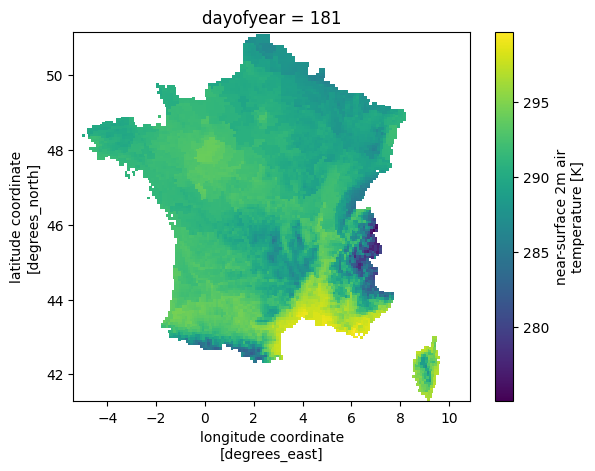

In [57]:
ds_test["Tair"][180, :, :].plot()

In [58]:
safran_extract_from_index(ds_test["Tair"][180, :, :], plat, plon)

292.5993347167969

# Load and Transform Coordinates


In [61]:
subset_of_coors = True
n_subset = 100

In [62]:
# Load latest coordinates for nfi sites
site_coordinates = pd.read_csv("../00_process_nfi_data/nfi_final_sites_with_idp.csv")

# Get subset of sites if desired
if subset_of_coors:
    site_coordinates = site_coordinates.sample(n_subset, random_state=42)

# Get a random set of sites to highlight
random_sites = site_coordinates.sample(9, random_state=42)["idp"]
site_coordinates

,first_year,SiteID,x,y,idp,x_fr,y_fr
14224,2015,14225,5.123290,48.949017,1031155,8.554986e+05,6.874208e+06
14399,2016,14400,5.780498,47.743949,1104466,9.083272e+05,6.741841e+06
2299,2012,2300,5.488906,47.329123,711269,8.879398e+05,6.695051e+06
6650,2010,6651,4.131339,47.897959,537195,7.845344e+05,6.755891e+06
21027,2011,21028,0.301426,43.161639,641084,4.804160e+05,6.232908e+06
...,...,...,...,...,...,...,...
10840,2013,10841,0.832516,48.207857,825676,5.390042e+05,6.791933e+06
3434,2013,3435,-3.030482,48.058722,827113,2.511841e+05,6.790296e+06
19511,2011,19512,6.389746,44.364497,608245,9.700572e+05,6.368627e+06
36491,2015,36492,-1.326894,44.045121,1028177,3.534045e+05,6.336845e+06


In [63]:
df_sites = site_coordinates[["idp", "first_year", "x", "y"]]
df_list = df_sites.groupby("idp")
df_list = [df for _, df in df_list]

In [64]:
df_list[0]
ffolder[0]

'../../data/raw/safran/ORCHIDEE_France-8km-1hour_2000_fromSAFRAN.nc'

In [68]:
from utilities import safran_extract_data_per_site

safran_extract_data_per_site(
    site_in=df_list[0],
    nc_filepath=ffolder[0],
    verbose=True,
)

    - Working on variable: 1/8


        - Working on hour: 100%|██████████| 366/366 [00:00<00:00, 1495.62it/s]


    - Working on variable: 2/8


        - Working on hour: 100%|██████████| 366/366 [00:00<00:00, 1582.64it/s]


    - Working on variable: 3/8


        - Working on hour: 100%|██████████| 366/366 [00:00<00:00, 1571.32it/s]


    - Working on variable: 4/8


        - Working on hour: 100%|██████████| 366/366 [00:00<00:00, 1561.72it/s]


    - Working on variable: 5/8


        - Working on hour: 100%|██████████| 366/366 [00:00<00:00, 1527.31it/s]


    - Working on variable: 6/8


        - Working on hour: 100%|██████████| 366/366 [00:00<00:00, 1551.22it/s]


    - Working on variable: 7/8


        - Working on hour: 100%|██████████| 366/366 [00:00<00:00, 1522.04it/s]


    - Working on variable: 8/8


        - Working on hour: 100%|██████████| 366/366 [00:00<00:00, 1502.86it/s]


,lat,lon,tstep,variable,value
0,47.3915,0.378553,1,Qair,0.006492
0,47.3915,0.378553,2,Qair,0.006485
0,47.3915,0.378553,3,Qair,0.006479
0,47.3915,0.378553,4,Qair,0.006473
0,47.3915,0.378553,5,Qair,0.006467
...,...,...,...,...,...
0,47.3915,0.378553,362,PSurf,100213.382812
0,47.3915,0.378553,363,PSurf,100213.382812
0,47.3915,0.378553,364,PSurf,100213.382812
0,47.3915,0.378553,365,PSurf,100213.382812


❌ Add checks -> Extract hourly for one site and plot all variable. On top, plot the extract max, mean, min to see if it mathces!


In [26]:
from utilities import safran_extract_data_per_site

df_mp = run_mp(
    safran_extract_data_per_site,
    df_list,
    num_cores=10,
    progress_bar=True,
    nc_filepath=ffolder[0],
)

  0%|          | 0/100 [00:00<?, ?it/s]

    - Working on variable: 1/8
    - Working on variable: 1/8
    - Working on variable: 1/8
    - Working on variable: 1/8
    - Working on variable: 1/8
    - Working on variable: 1/8
    - Working on variable: 1/8
    - Working on variable: 1/8
    - Working on variable: 1/8


        - Working on hour:   1%|          | 71/8784 [00:00<00:36, 238.37it/s]

    - Working on variable: 1/8


        - Working on hour:  92%|█████████▏| 8071/8784 [00:32<00:02, 256.26it/s]

    - Working on variable: 2/8


        - Working on hour: 100%|█████████▉| 8742/8784 [00:35<00:00, 229.05it/s]

    - Working on variable: 2/8
    - Working on variable: 2/8


        - Working on hour:  96%|█████████▋| 8460/8784 [00:35<00:01, 209.12it/s]

    - Working on variable: 2/8


        - Working on hour:   0%|          | 0/8784 [00:00<?, ?it/s]

    - Working on variable: 2/8
    - Working on variable: 2/8


        - Working on hour:  99%|█████████▉| 8702/8784 [00:37<00:00, 241.84it/s]

    - Working on variable: 2/8


        - Working on hour:   4%|▍         | 373/8784 [00:01<00:34, 242.64it/s]]

    - Working on variable: 2/8
    - Working on variable: 2/8
    - Working on variable: 2/8


        - Working on hour:  91%|█████████ | 7964/8784 [00:30<00:03, 249.98it/s]

    - Working on variable: 3/8


        - Working on hour:  86%|████████▋ | 7584/8784 [00:33<00:05, 225.24it/s]

    - Working on variable: 3/8
    - Working on variable: 3/8
    - Working on variable: 3/8
    - Working on variable: 3/8
    - Working on variable: 3/8


        - Working on hour:  13%|█▎        | 1132/8784 [00:04<00:32, 234.07it/s]

    - Working on variable: 3/8


        - Working on hour:  14%|█▍        | 1245/8784 [00:04<00:30, 243.84it/s]

    - Working on variable: 3/8


        - Working on hour:  15%|█▌        | 1359/8784 [00:05<00:36, 203.13it/s]

    - Working on variable: 3/8
    - Working on variable: 3/8


        - Working on hour:  93%|█████████▎| 8176/8784 [00:32<00:02, 203.87it/s]

    - Working on variable: 4/8


        - Working on hour: 100%|█████████▉| 8757/8784 [00:35<00:00, 249.61it/s]

    - Working on variable: 4/8
    - Working on variable: 4/8
    - Working on variable: 4/8


        - Working on hour:  98%|█████████▊| 8580/8784 [00:35<00:00, 239.44it/s]

    - Working on variable: 4/8


        - Working on hour:   0%|          | 22/8784 [00:00<00:40, 217.79it/s]s]

    - Working on variable: 4/8


        - Working on hour:  96%|█████████▌| 8398/8784 [00:38<00:01, 241.57it/s]

    - Working on variable: 4/8


        - Working on hour:  23%|██▎       | 2044/8784 [00:08<00:27, 243.37it/s]

    - Working on variable: 4/8


        - Working on hour:  36%|███▌      | 3154/8784 [00:13<00:25, 221.07it/s]

    - Working on variable: 4/8
    - Working on variable: 4/8


        - Working on hour:  70%|██████▉   | 6144/8784 [00:29<00:15, 169.67it/s]

    - Working on variable: 5/8


        - Working on hour:  98%|█████████▊| 8646/8784 [00:44<00:00, 233.43it/s]

    - Working on variable: 5/8


        - Working on hour:  71%|███████   | 6207/8784 [00:35<00:12, 205.32it/s]

    - Working on variable: 5/8


        - Working on hour:   0%|          | 21/8784 [00:00<00:42, 206.75it/s]s]

    - Working on variable: 5/8
    - Working on variable: 5/8


        - Working on hour:  75%|███████▍  | 6573/8784 [00:36<00:11, 198.62it/s]

    - Working on variable: 5/8


        - Working on hour:  12%|█▏        | 1090/8784 [00:04<00:32, 239.72it/s]

    - Working on variable: 5/8
    - Working on variable: 5/8


        - Working on hour:  38%|███▊      | 3318/8784 [00:15<00:24, 224.82it/s]

    - Working on variable: 5/8


        - Working on hour:   1%|          | 51/8784 [00:00<00:34, 251.82it/s]s]

    - Working on variable: 5/8


        - Working on hour:   0%|          | 0/8784 [00:00<?, ?it/s]

    - Working on variable: 6/8


        - Working on hour:  80%|███████▉  | 7008/8784 [00:33<00:08, 213.13it/s]

    - Working on variable: 6/8


        - Working on hour:   9%|▉         | 801/8784 [00:03<00:37, 210.91it/s]]

    - Working on variable: 6/8


        - Working on hour:  96%|█████████▌| 8449/8784 [00:37<00:02, 158.26it/s]

    - Working on variable: 6/8


        - Working on hour:  83%|████████▎ | 7295/8784 [00:34<00:06, 214.47it/s]

    - Working on variable: 6/8


        - Working on hour:  86%|████████▌ | 7529/8784 [00:35<00:06, 207.57it/s]

    - Working on variable: 6/8


        - Working on hour:  20%|█▉        | 1749/8784 [00:08<00:33, 208.61it/s]

    - Working on variable: 6/8


        - Working on hour:   0%|          | 0/8784 [00:00<?, ?it/s]

    - Working on variable: 6/8


        - Working on hour:  35%|███▌      | 3116/8784 [00:15<00:25, 222.09it/s]

    - Working on variable: 6/8


        - Working on hour:  37%|███▋      | 3210/8784 [00:15<00:27, 205.93it/s]

    - Working on variable: 6/8


        - Working on hour:  93%|█████████▎| 8146/8784 [00:36<00:03, 202.44it/s]

    - Working on variable: 7/8


        - Working on hour:  96%|█████████▌| 8423/8784 [00:38<00:01, 214.59it/s]

    - Working on variable: 7/8
    - Working on variable: 7/8


        - Working on hour:   0%|          | 0/8784 [00:00<?, ?it/s]

    - Working on variable: 7/8


        - Working on hour:   3%|▎         | 238/8784 [00:01<00:37, 228.23it/s]]

    - Working on variable: 7/8
    - Working on variable: 7/8


        - Working on hour:  28%|██▊       | 2490/8784 [00:12<00:30, 204.39it/s]

    - Working on variable: 7/8


        - Working on hour:  26%|██▌       | 2270/8784 [00:11<00:35, 183.41it/s]

    - Working on variable: 7/8


        - Working on hour:   0%|          | 23/8784 [00:00<00:40, 218.70it/s]s]

    - Working on variable: 7/8
    - Working on variable: 7/8


        - Working on hour:  93%|█████████▎| 8186/8784 [00:37<00:02, 224.78it/s]

    - Working on variable: 8/8


        - Working on hour:  66%|██████▌   | 5783/8784 [00:28<00:15, 195.11it/s]

    - Working on variable: 8/8
    - Working on variable: 8/8


        - Working on hour:  61%|██████    | 5325/8784 [00:26<00:17, 198.71it/s]

    - Working on variable: 8/8


        - Working on hour:  63%|██████▎   | 5560/8784 [00:27<00:18, 172.14it/s]

    - Working on variable: 8/8


        - Working on hour:   6%|▌         | 530/8784 [00:02<00:49, 167.55it/s]]

    - Working on variable: 8/8


        - Working on hour:  35%|███▌      | 3104/8784 [00:14<00:31, 180.48it/s]

    - Working on variable: 8/8


        - Working on hour:  48%|████▊     | 4216/8784 [00:19<00:20, 223.18it/s]

    - Working on variable: 8/8


        - Working on hour:   4%|▍         | 368/8784 [00:02<00:52, 159.89it/s]

    - Working on variable: 8/8
    - Working on variable: 8/8


        - Working on hour:   0%|          | 33/8784 [00:00<00:26, 324.41it/s]s]

    - Working on variable: 1/8


        - Working on hour:   0%|          | 39/8784 [00:00<00:22, 389.88it/s]s]

    - Working on variable: 1/8
    - Working on variable: 1/8


        - Working on hour:   2%|▏         | 172/8784 [00:00<00:30, 278.52it/s]]

    - Working on variable: 1/8


        - Working on hour:   0%|          | 25/8784 [00:00<00:35, 247.60it/s]s]

    - Working on variable: 1/8
    - Working on variable: 1/8


        - Working on hour:   0%|          | 18/8784 [00:00<00:49, 178.39it/s]s]

    - Working on variable: 1/8


        - Working on hour:  51%|█████     | 4485/8784 [00:18<00:20, 207.76it/s]

    - Working on variable: 1/8


        - Working on hour:   3%|▎         | 304/8784 [00:01<00:31, 266.10it/s]]

    - Working on variable: 1/8
    - Working on variable: 1/8


        - Working on hour:   0%|          | 0/8784 [00:00<?, ?it/s]

    - Working on variable: 2/8


        - Working on hour:  98%|█████████▊| 8633/8784 [00:36<00:00, 234.87it/s]

    - Working on variable: 2/8


        - Working on hour:   0%|          | 0/8784 [00:00<?, ?it/s]

    - Working on variable: 2/8
    - Working on variable: 2/8


        - Working on hour:   0%|          | 0/8784 [00:00<?, ?it/s]

    - Working on variable: 2/8
    - Working on variable: 2/8


        - Working on hour:   0%|          | 0/8784 [00:00<?, ?it/s]

    - Working on variable: 2/8


        - Working on hour:   0%|          | 32/8784 [00:00<00:27, 314.40it/s]s]

    - Working on variable: 2/8


        - Working on hour:  52%|█████▏    | 4565/8784 [00:19<00:17, 239.42it/s]

    - Working on variable: 2/8


        - Working on hour:  56%|█████▌    | 4926/8784 [00:22<00:19, 197.97it/s]

    - Working on variable: 2/8


        - Working on hour:  48%|████▊     | 4196/8784 [00:17<00:18, 252.30it/s]

    - Working on variable: 3/8
    - Working on variable: 3/8
    - Working on variable: 3/8


        - Working on hour:  60%|█████▉    | 5265/8784 [00:20<00:14, 239.12it/s]

    - Working on variable: 3/8


        - Working on hour:   7%|▋         | 611/8784 [00:03<00:44, 182.21it/s]]

    - Working on variable: 3/8
    - Working on variable: 3/8


        - Working on hour:   1%|          | 57/8784 [00:00<00:30, 284.70it/s]s]

    - Working on variable: 3/8


        - Working on hour:  50%|████▉     | 4358/8784 [00:19<00:19, 225.70it/s]

    - Working on variable: 3/8


        - Working on hour:   4%|▎         | 321/8784 [00:01<00:42, 200.31it/s]]

    - Working on variable: 3/8
    - Working on variable: 3/8


        - Working on hour:  95%|█████████▍| 8321/8784 [00:38<00:02, 213.28it/s]

    - Working on variable: 4/8
    - Working on variable: 4/8


        - Working on hour:  54%|█████▍    | 4749/8784 [00:19<00:17, 236.73it/s]

    - Working on variable: 4/8
    - Working on variable: 4/8


        - Working on hour:   0%|          | 41/8784 [00:00<00:41, 209.06it/s]]]

    - Working on variable: 4/8
    - Working on variable: 4/8


        - Working on hour:  76%|███████▌  | 6688/8784 [00:27<00:08, 250.62it/s]

    - Working on variable: 4/8


        - Working on hour:  97%|█████████▋| 8539/8784 [00:35<00:00, 261.55it/s]

    - Working on variable: 4/8


        - Working on hour:  37%|███▋      | 3216/8784 [00:15<00:25, 219.26it/s]

    - Working on variable: 4/8
    - Working on variable: 4/8


        - Working on hour:  94%|█████████▎| 8225/8784 [00:31<00:02, 240.85it/s]

    - Working on variable: 5/8
    - Working on variable: 5/8


        - Working on hour:  66%|██████▌   | 5813/8784 [00:24<00:12, 246.47it/s]

    - Working on variable: 5/8
    - Working on variable: 5/8
    - Working on variable: 5/8


        - Working on hour:  72%|███████▏  | 6291/8784 [00:26<00:09, 261.10it/s]

    - Working on variable: 5/8
    - Working on variable: 5/8


        - Working on hour:  37%|███▋      | 3286/8784 [00:15<00:25, 215.28it/s]

    - Working on variable: 5/8
    - Working on variable: 5/8


        - Working on hour:  40%|███▉      | 3511/8784 [00:15<00:23, 220.33it/s]

    - Working on variable: 5/8


        - Working on hour:  88%|████████▊ | 7743/8784 [00:37<00:04, 213.26it/s]

    - Working on variable: 6/8
    - Working on variable: 6/8


        - Working on hour:  90%|█████████ | 7926/8784 [00:39<00:05, 153.71it/s]

    - Working on variable: 6/8
    - Working on variable: 6/8


        - Working on hour:  63%|██████▎   | 5498/8784 [00:26<00:21, 152.39it/s]

    - Working on variable: 6/8


        - Working on hour:  82%|████████▏ | 7175/8784 [00:33<00:08, 195.94it/s]

    - Working on variable: 6/8
    - Working on variable: 6/8


        - Working on hour:  30%|██▉       | 2614/8784 [00:12<00:25, 238.69it/s]

    - Working on variable: 6/8
    - Working on variable: 6/8


        - Working on hour:  13%|█▎        | 1108/8784 [00:04<00:34, 223.08it/s]

    - Working on variable: 6/8


        - Working on hour:   0%|          | 43/8784 [00:00<00:40, 214.48it/s]s]

    - Working on variable: 7/8


        - Working on hour:  94%|█████████▍| 8242/8784 [00:38<00:03, 170.14it/s]

    - Working on variable: 7/8


        - Working on hour:   3%|▎         | 305/8784 [00:01<00:39, 217.18it/s]]

    - Working on variable: 7/8
    - Working on variable: 7/8


        - Working on hour:   7%|▋         | 622/8784 [00:03<00:38, 212.89it/s]]

    - Working on variable: 7/8


        - Working on hour:  86%|████████▌ | 7525/8784 [00:34<00:05, 223.20it/s]

    - Working on variable: 7/8
    - Working on variable: 7/8


        - Working on hour:  95%|█████████▍| 8329/8784 [00:35<00:02, 200.44it/s]

    - Working on variable: 7/8
    - Working on variable: 7/8


        - Working on hour:  19%|█▊        | 1640/8784 [00:07<00:35, 203.00it/s]

    - Working on variable: 7/8


        - Working on hour:  63%|██████▎   | 5520/8784 [00:27<00:20, 162.77it/s]

    - Working on variable: 8/8


        - Working on hour:  96%|█████████▌| 8390/8784 [00:41<00:01, 208.68it/s]

    - Working on variable: 8/8


        - Working on hour:  74%|███████▍  | 6533/8784 [00:32<00:11, 196.41it/s]

    - Working on variable: 8/8
    - Working on variable: 8/8


        - Working on hour:  91%|█████████▏| 8030/8784 [00:41<00:04, 179.42it/s]

    - Working on variable: 8/8


        - Working on hour:  89%|████████▉ | 7855/8784 [00:37<00:04, 200.99it/s]

    - Working on variable: 8/8
    - Working on variable: 8/8


        - Working on hour:   0%|          | 22/8784 [00:00<00:40, 218.07it/s]]]

    - Working on variable: 8/8
    - Working on variable: 8/8


        - Working on hour:  12%|█▏        | 1036/8784 [00:05<00:38, 201.96it/s]

    - Working on variable: 8/8


        - Working on hour:   0%|          | 33/8784 [00:00<00:27, 317.13it/s]s]

    - Working on variable: 1/8


        - Working on hour:  77%|███████▋  | 6756/8784 [00:32<00:10, 188.34it/s]

    - Working on variable: 1/8


        - Working on hour:  93%|█████████▎| 8152/8784 [00:39<00:02, 211.35it/s]

    - Working on variable: 1/8
    - Working on variable: 1/8


        - Working on hour:  25%|██▌       | 2235/8784 [00:08<00:25, 253.57it/s]

    - Working on variable: 1/8


        - Working on hour:  11%|█         | 957/8784 [00:03<00:29, 269.68it/s]]

    - Working on variable: 1/8


        - Working on hour:  92%|█████████▏| 8118/8784 [00:37<00:04, 165.27it/s]

    - Working on variable: 1/8


 19%|█▉        | 19/100 [10:50<12:06,  8.97s/it]

    - Working on variable: 1/8


        - Working on hour:  37%|███▋      | 3282/8784 [00:14<00:23, 233.92it/s]

    - Working on variable: 1/8
    - Working on variable: 1/8


        - Working on hour:  80%|████████  | 7041/8784 [00:25<00:06, 286.07it/s]

    - Working on variable: 2/8


        - Working on hour:   0%|          | 17/8784 [00:00<00:51, 169.76it/s]s]

    - Working on variable: 2/8


        - Working on hour:  91%|█████████ | 7951/8784 [00:29<00:03, 237.67it/s]

    - Working on variable: 2/8
    - Working on variable: 2/8


        - Working on hour:  77%|███████▋  | 6770/8784 [00:28<00:08, 232.07it/s]

    - Working on variable: 2/8


        - Working on hour:  92%|█████████▏| 8107/8784 [00:33<00:02, 248.65it/s]

    - Working on variable: 2/8


        - Working on hour:   8%|▊         | 745/8784 [00:02<00:28, 278.29it/s]]

    - Working on variable: 2/8


        - Working on hour:  25%|██▌       | 2205/8784 [00:08<00:25, 261.48it/s]

    - Working on variable: 2/8
    - Working on variable: 2/8


        - Working on hour:  25%|██▍       | 2171/8784 [00:08<00:26, 249.57it/s]

    - Working on variable: 2/8


        - Working on hour:  66%|██████▌   | 5786/8784 [00:23<00:10, 274.06it/s]

    - Working on variable: 3/8


        - Working on hour:  93%|█████████▎| 8190/8784 [00:33<00:02, 218.37it/s]

    - Working on variable: 3/8


        - Working on hour:   0%|          | 0/8784 [00:00<?, ?it/s]

    - Working on variable: 3/8
    - Working on variable: 3/8


        - Working on hour:  85%|████████▍ | 7429/8784 [00:29<00:06, 221.24it/s]

    - Working on variable: 3/8


        - Working on hour:   0%|          | 28/8784 [00:00<00:31, 278.43it/s]s]

    - Working on variable: 3/8


        - Working on hour:   7%|▋         | 578/8784 [00:02<00:35, 233.75it/s]]

    - Working on variable: 3/8


        - Working on hour:   0%|          | 30/8784 [00:00<00:29, 299.96it/s]s]

    - Working on variable: 3/8


        - Working on hour:  98%|█████████▊| 8632/8784 [00:35<00:00, 265.47it/s]

    - Working on variable: 3/8


        - Working on hour:   4%|▎         | 318/8784 [00:01<00:36, 234.51it/s]]

    - Working on variable: 3/8


        - Working on hour:  69%|██████▉   | 6092/8784 [00:24<00:10, 250.07it/s]

    - Working on variable: 4/8


        - Working on hour:  85%|████████▌ | 7498/8784 [00:29<00:05, 254.73it/s]

    - Working on variable: 4/8


        - Working on hour:   6%|▌         | 526/8784 [00:02<00:33, 247.13it/s]]

    - Working on variable: 4/8
    - Working on variable: 4/8


        - Working on hour:   1%|          | 95/8784 [00:00<00:33, 259.12it/s]]]

    - Working on variable: 4/8


        - Working on hour:   1%|          | 50/8784 [00:00<00:35, 248.32it/s]s]

    - Working on variable: 4/8


        - Working on hour:  17%|█▋        | 1450/8784 [00:05<00:30, 242.75it/s]

    - Working on variable: 4/8


        - Working on hour:   0%|          | 28/8784 [00:00<00:31, 278.39it/s]s]

    - Working on variable: 4/8
    - Working on variable: 4/8


        - Working on hour:  35%|███▍      | 3060/8784 [00:13<00:23, 243.86it/s]

    - Working on variable: 4/8


        - Working on hour:  83%|████████▎ | 7283/8784 [00:30<00:05, 265.93it/s]

    - Working on variable: 5/8


        - Working on hour:  54%|█████▍    | 4727/8784 [00:20<00:17, 235.56it/s]

    - Working on variable: 5/8


        - Working on hour:  90%|█████████ | 7925/8784 [00:32<00:02, 288.39it/s]

    - Working on variable: 5/8


        - Working on hour:  92%|█████████▏| 8044/8784 [00:33<00:02, 255.54it/s]

    - Working on variable: 5/8


        - Working on hour:  17%|█▋        | 1523/8784 [00:05<00:27, 265.21it/s]

    - Working on variable: 5/8


        - Working on hour:  26%|██▌       | 2252/8784 [00:10<00:32, 201.84it/s]

    - Working on variable: 5/8


        - Working on hour:  77%|███████▋  | 6747/8784 [00:29<00:09, 215.71it/s]

    - Working on variable: 5/8


        - Working on hour:  24%|██▍       | 2097/8784 [00:08<00:28, 231.93it/s]

    - Working on variable: 5/8


        - Working on hour:   0%|          | 0/8784 [00:00<?, ?it/s]

    - Working on variable: 5/8


        - Working on hour:  42%|████▏     | 3681/8784 [00:16<00:23, 219.16it/s]

    - Working on variable: 5/8


        - Working on hour:  41%|████▏     | 3637/8784 [00:17<00:24, 213.05it/s]

    - Working on variable: 6/8


        - Working on hour:  73%|███████▎  | 6395/8784 [00:31<00:12, 198.54it/s]

    - Working on variable: 6/8


        - Working on hour:   7%|▋         | 619/8784 [00:02<00:37, 219.70it/s]]

    - Working on variable: 6/8


        - Working on hour:  10%|▉         | 868/8784 [00:04<00:37, 212.94it/s]]

    - Working on variable: 6/8
    - Working on variable: 6/8


        - Working on hour:  90%|█████████ | 7919/8784 [00:38<00:03, 222.25it/s]

    - Working on variable: 6/8


        - Working on hour:   0%|          | 0/8784 [00:00<?, ?it/s]

    - Working on variable: 6/8


        - Working on hour:  37%|███▋      | 3219/8784 [00:14<00:22, 251.00it/s]

    - Working on variable: 6/8


        - Working on hour:  44%|████▎     | 3823/8784 [00:17<00:24, 202.92it/s]

    - Working on variable: 6/8


        - Working on hour:  55%|█████▍    | 4807/8784 [00:22<00:22, 173.36it/s]

    - Working on variable: 6/8


        - Working on hour:   0%|          | 26/8784 [00:00<00:34, 250.26it/s]s]

    - Working on variable: 7/8


        - Working on hour:   6%|▌         | 505/8784 [00:02<00:44, 188.03it/s]]

    - Working on variable: 7/8
    - Working on variable: 7/8


        - Working on hour:   0%|          | 0/8784 [00:00<?, ?it/s]

    - Working on variable: 7/8


        - Working on hour:  78%|███████▊  | 6822/8784 [00:32<00:09, 196.86it/s]

    - Working on variable: 7/8


        - Working on hour:  12%|█▏        | 1088/8784 [00:05<00:34, 220.70it/s]

    - Working on variable: 7/8


        - Working on hour:  77%|███████▋  | 6776/8784 [00:31<00:08, 230.24it/s]

    - Working on variable: 7/8


        - Working on hour:  33%|███▎      | 2900/8784 [00:12<00:24, 236.92it/s]

    - Working on variable: 7/8


        - Working on hour:  49%|████▉     | 4331/8784 [00:20<00:21, 204.04it/s]

    - Working on variable: 7/8


        - Working on hour:  53%|█████▎    | 4639/8784 [00:22<00:19, 211.07it/s]

    - Working on variable: 7/8


        - Working on hour:   0%|          | 0/8784 [00:00<?, ?it/s]

    - Working on variable: 8/8


        - Working on hour:  96%|█████████▋| 8455/8784 [00:40<00:01, 169.84it/s]

    - Working on variable: 8/8


        - Working on hour:   0%|          | 21/8784 [00:00<00:42, 207.96it/s]s]

    - Working on variable: 8/8
    - Working on variable: 8/8


        - Working on hour:  70%|███████   | 6190/8784 [00:30<00:10, 238.43it/s]

    - Working on variable: 8/8


        - Working on hour:  80%|███████▉  | 7021/8784 [00:34<00:08, 201.46it/s]

    - Working on variable: 8/8


        - Working on hour:  23%|██▎       | 2020/8784 [00:08<00:26, 257.72it/s]

    - Working on variable: 8/8


        - Working on hour:  78%|███████▊  | 6829/8784 [00:33<00:10, 195.10it/s]

    - Working on variable: 8/8


        - Working on hour:  14%|█▍        | 1215/8784 [00:05<00:33, 222.90it/s]

    - Working on variable: 8/8


        - Working on hour:  57%|█████▋    | 5025/8784 [00:21<00:14, 253.36it/s]

    - Working on variable: 8/8


 24%|██▍       | 24/100 [15:42<42:13, 33.33s/it]

    - Working on variable: 1/8
    - Working on variable: 1/8
    - Working on variable: 1/8


        - Working on hour:   1%|          | 73/8784 [00:00<00:43, 201.48it/s]s]

    - Working on variable: 1/8


        - Working on hour:  44%|████▎     | 3831/8784 [00:17<00:25, 194.87it/s]

    - Working on variable: 1/8


        - Working on hour:   2%|▏         | 166/8784 [00:00<00:32, 262.33it/s]]

    - Working on variable: 1/8


        - Working on hour:  34%|███▍      | 2966/8784 [00:12<00:24, 237.28it/s]

    - Working on variable: 1/8


        - Working on hour:  37%|███▋      | 3252/8784 [00:13<00:23, 237.29it/s]

    - Working on variable: 1/8


        - Working on hour:  50%|█████     | 4392/8784 [00:17<00:15, 280.79it/s]

    - Working on variable: 1/8


        - Working on hour:  20%|█▉        | 1724/8784 [00:07<00:29, 237.08it/s]

    - Working on variable: 1/8


        - Working on hour:  97%|█████████▋| 8564/8784 [00:34<00:01, 213.27it/s]

    - Working on variable: 2/8


        - Working on hour:  97%|█████████▋| 8505/8784 [00:34<00:01, 252.45it/s]

    - Working on variable: 2/8
    - Working on variable: 2/8
    - Working on variable: 2/8


        - Working on hour:  52%|█████▏    | 4556/8784 [00:17<00:15, 270.71it/s]

    - Working on variable: 2/8


        - Working on hour:  36%|███▌      | 3154/8784 [00:11<00:20, 271.01it/s]

    - Working on variable: 2/8


        - Working on hour:  31%|███       | 2729/8784 [00:10<00:22, 270.92it/s]

    - Working on variable: 2/8


        - Working on hour:   0%|          | 27/8784 [00:00<00:33, 264.64it/s]s]

    - Working on variable: 2/8


        - Working on hour:  15%|█▌        | 1343/8784 [00:05<00:31, 233.20it/s]

    - Working on variable: 2/8


        - Working on hour:  64%|██████▍   | 5644/8784 [00:22<00:14, 212.28it/s]

    - Working on variable: 2/8


        - Working on hour:   0%|          | 26/8784 [00:00<00:34, 255.31it/s]s]

    - Working on variable: 3/8


        - Working on hour:   0%|          | 40/8784 [00:00<00:43, 202.56it/s]s]

    - Working on variable: 3/8


        - Working on hour:   0%|          | 30/8784 [00:00<00:29, 294.45it/s]]

    - Working on variable: 3/8
    - Working on variable: 3/8
    - Working on variable: 3/8


        - Working on hour:  71%|███████   | 6257/8784 [00:25<00:10, 252.66it/s]

    - Working on variable: 3/8


        - Working on hour:  64%|██████▍   | 5615/8784 [00:22<00:13, 240.02it/s]

    - Working on variable: 3/8


        - Working on hour:   0%|          | 23/8784 [00:00<00:38, 229.15it/s]s]

    - Working on variable: 3/8


        - Working on hour:  50%|████▉     | 4367/8784 [00:17<00:17, 248.99it/s]

    - Working on variable: 3/8


        - Working on hour:  68%|██████▊   | 5950/8784 [00:23<00:12, 223.90it/s]

    - Working on variable: 3/8


        - Working on hour:  84%|████████▍ | 7370/8784 [00:28<00:04, 290.98it/s]

    - Working on variable: 4/8


        - Working on hour:  64%|██████▎   | 5579/8784 [00:22<00:12, 267.04it/s]

    - Working on variable: 4/8


        - Working on hour:  52%|█████▏    | 4581/8784 [00:18<00:17, 242.03it/s]

    - Working on variable: 4/8


        - Working on hour:  70%|███████   | 6158/8784 [00:24<00:10, 250.20it/s]

    - Working on variable: 4/8
    - Working on variable: 4/8


        - Working on hour:  70%|███████   | 6186/8784 [00:24<00:09, 271.71it/s]

    - Working on variable: 4/8


        - Working on hour:   0%|          | 0/8784 [00:00<?, ?it/s]

    - Working on variable: 4/8


        - Working on hour:   4%|▍         | 355/8784 [00:01<00:39, 216.05it/s]]

    - Working on variable: 4/8


        - Working on hour:  42%|████▏     | 3683/8784 [00:16<00:23, 221.22it/s]

    - Working on variable: 4/8


        - Working on hour:  69%|██████▉   | 6052/8784 [00:25<00:12, 227.20it/s]

    - Working on variable: 4/8


        - Working on hour:  72%|███████▏  | 6336/8784 [00:27<00:09, 253.16it/s]

    - Working on variable: 5/8


        - Working on hour:  46%|████▌     | 4022/8784 [00:18<00:20, 230.40it/s]

    - Working on variable: 5/8


        - Working on hour:  92%|█████████▏| 8074/8784 [00:36<00:03, 233.30it/s]

    - Working on variable: 5/8
    - Working on variable: 5/8


        - Working on hour:  28%|██▊       | 2497/8784 [00:10<00:28, 218.99it/s]

    - Working on variable: 5/8


        - Working on hour:  35%|███▌      | 3086/8784 [00:13<00:24, 231.51it/s]

    - Working on variable: 5/8


        - Working on hour:   0%|          | 22/8784 [00:00<00:41, 212.74it/s]s]

    - Working on variable: 5/8


        - Working on hour:   0%|          | 26/8784 [00:00<00:33, 258.04it/s]s]

    - Working on variable: 5/8


        - Working on hour:  51%|█████▏    | 4503/8784 [00:18<00:20, 213.44it/s]

    - Working on variable: 5/8


        - Working on hour:  43%|████▎     | 3761/8784 [00:15<00:19, 251.80it/s]

    - Working on variable: 5/8


        - Working on hour:  82%|████████▏ | 7198/8784 [00:28<00:05, 268.36it/s]

    - Working on variable: 6/8


        - Working on hour:  89%|████████▉ | 7856/8784 [00:33<00:04, 214.73it/s]

    - Working on variable: 6/8


        - Working on hour:  26%|██▌       | 2255/8784 [00:10<00:26, 242.53it/s]

    - Working on variable: 6/8


        - Working on hour:  12%|█▏        | 1074/8784 [00:04<00:28, 268.72it/s]

    - Working on variable: 6/8
    - Working on variable: 6/8


        - Working on hour:   0%|          | 0/8784 [00:00<?, ?it/s]

    - Working on variable: 6/8


        - Working on hour:   0%|          | 32/8784 [00:00<00:27, 313.20it/s]s]

    - Working on variable: 6/8
    - Working on variable: 6/8


        - Working on hour:  32%|███▏      | 2843/8784 [00:12<00:22, 261.39it/s]

    - Working on variable: 6/8


        - Working on hour:  49%|████▉     | 4338/8784 [00:19<00:21, 209.17it/s]

    - Working on variable: 6/8


        - Working on hour:   0%|          | 0/8784 [00:00<?, ?it/s]

    - Working on variable: 7/8


        - Working on hour:  88%|████████▊ | 7736/8784 [00:35<00:04, 244.93it/s]

    - Working on variable: 7/8


        - Working on hour:  10%|▉         | 847/8784 [00:03<00:33, 237.42it/s]]

    - Working on variable: 7/8


        - Working on hour:   0%|          | 0/8784 [00:00<?, ?it/s]

    - Working on variable: 7/8
    - Working on variable: 7/8


        - Working on hour:  96%|█████████▋| 8460/8784 [00:38<00:01, 254.21it/s]

    - Working on variable: 7/8


        - Working on hour:  20%|█▉        | 1741/8784 [00:07<00:30, 230.19it/s]

    - Working on variable: 7/8


        - Working on hour:  50%|█████     | 4429/8784 [00:20<00:19, 226.61it/s]

    - Working on variable: 7/8


        - Working on hour:   0%|          | 0/8784 [00:00<?, ?it/s]

    - Working on variable: 7/8


        - Working on hour:   0%|          | 0/8784 [00:00<?, ?it/s]

    - Working on variable: 8/8
    - Working on variable: 7/8


        - Working on hour:  17%|█▋        | 1460/8784 [00:06<00:32, 222.32it/s]

    - Working on variable: 8/8


        - Working on hour:  96%|█████████▌| 8406/8784 [00:37<00:01, 221.53it/s]

    - Working on variable: 8/8


        - Working on hour:  37%|███▋      | 3207/8784 [00:12<00:19, 281.94it/s]

    - Working on variable: 8/8
    - Working on variable: 8/8


        - Working on hour:  32%|███▏      | 2816/8784 [00:11<00:28, 212.07it/s]

    - Working on variable: 8/8


        - Working on hour:   3%|▎         | 229/8784 [00:01<00:40, 211.46it/s]]

    - Working on variable: 8/8


        - Working on hour:  36%|███▋      | 3193/8784 [00:13<00:26, 212.45it/s]

    - Working on variable: 8/8


        - Working on hour:  86%|████████▌ | 7552/8784 [00:33<00:05, 205.46it/s]

    - Working on variable: 8/8


        - Working on hour:  79%|███████▉  | 6944/8784 [00:30<00:08, 206.38it/s]

    - Working on variable: 1/8


        - Working on hour:  74%|███████▍  | 6506/8784 [00:29<00:10, 219.17it/s]

    - Working on variable: 8/8


        - Working on hour:  83%|████████▎ | 7333/8784 [00:33<00:05, 243.38it/s]

    - Working on variable: 1/8


        - Working on hour:  82%|████████▏ | 7208/8784 [00:32<00:06, 238.35it/s]

    - Working on variable: 1/8


        - Working on hour:  20%|█▉        | 1728/8784 [00:06<00:29, 237.93it/s]

    - Working on variable: 1/8
    - Working on variable: 1/8


        - Working on hour:  23%|██▎       | 2030/8784 [00:07<00:22, 300.81it/s]

    - Working on variable: 1/8


        - Working on hour:  63%|██████▎   | 5526/8784 [00:24<00:15, 209.26it/s]

    - Working on variable: 1/8


        - Working on hour:   5%|▌         | 468/8784 [00:01<00:29, 282.77it/s]]

    - Working on variable: 1/8


        - Working on hour:   0%|          | 30/8784 [00:00<00:30, 284.28it/s]s]

    - Working on variable: 2/8


        - Working on hour:  62%|██████▏   | 5469/8784 [00:21<00:13, 242.61it/s]

    - Working on variable: 1/8


        - Working on hour:  99%|█████████▉| 8716/8784 [00:34<00:00, 228.40it/s]

    - Working on variable: 1/8


        - Working on hour:  59%|█████▊    | 5148/8784 [00:19<00:14, 243.53it/s]

    - Working on variable: 2/8


        - Working on hour:  73%|███████▎  | 6430/8784 [00:24<00:08, 286.38it/s]

    - Working on variable: 2/8


        - Working on hour:  39%|███▉      | 3411/8784 [00:13<00:20, 259.83it/s]

    - Working on variable: 2/8


        - Working on hour:   2%|▏         | 152/8784 [00:00<00:33, 260.21it/s]]

    - Working on variable: 2/8


        - Working on hour:   9%|▉         | 797/8784 [00:03<00:29, 271.03it/s]]

    - Working on variable: 2/8


        - Working on hour:  11%|█         | 926/8784 [00:03<00:30, 258.26it/s]]

    - Working on variable: 2/8


        - Working on hour:   0%|          | 27/8784 [00:00<00:32, 269.95it/s]s]

    - Working on variable: 2/8


        - Working on hour:  98%|█████████▊| 8577/8784 [00:35<00:00, 231.94it/s]

    - Working on variable: 2/8


        - Working on hour:  42%|████▏     | 3661/8784 [00:15<00:21, 242.93it/s]

    - Working on variable: 3/8


        - Working on hour:  62%|██████▏   | 5430/8784 [00:22<00:12, 272.89it/s]

    - Working on variable: 2/8


        - Working on hour:   5%|▍         | 416/8784 [00:01<00:33, 251.68it/s]]

    - Working on variable: 3/8


        - Working on hour:  88%|████████▊ | 7687/8784 [00:31<00:04, 263.72it/s]

    - Working on variable: 3/8


        - Working on hour:   0%|          | 0/8784 [00:00<?, ?it/s]

    - Working on variable: 3/8


        - Working on hour:  81%|████████▏ | 7144/8784 [00:30<00:06, 239.67it/s]

    - Working on variable: 3/8


        - Working on hour:   0%|          | 26/8784 [00:00<00:34, 256.80it/s]s]

    - Working on variable: 3/8


        - Working on hour:   0%|          | 0/8784 [00:00<?, ?it/s]

    - Working on variable: 3/8


        - Working on hour:  26%|██▌       | 2276/8784 [00:09<00:26, 242.03it/s]

    - Working on variable: 3/8


        - Working on hour:  60%|█████▉    | 5232/8784 [00:21<00:16, 220.64it/s]

    - Working on variable: 3/8


        - Working on hour:  80%|███████▉  | 7019/8784 [00:29<00:07, 229.55it/s]

    - Working on variable: 4/8


        - Working on hour:  17%|█▋        | 1466/8784 [00:06<00:31, 234.57it/s]

    - Working on variable: 3/8


        - Working on hour:   0%|          | 24/8784 [00:00<00:37, 232.80it/s]s]

    - Working on variable: 4/8


        - Working on hour:  87%|████████▋ | 7615/8784 [00:32<00:04, 267.11it/s]

    - Working on variable: 4/8


        - Working on hour:  84%|████████▍ | 7365/8784 [00:31<00:06, 227.58it/s]

    - Working on variable: 4/8


        - Working on hour:   0%|          | 0/8784 [00:00<?, ?it/s]

    - Working on variable: 4/8


        - Working on hour:  14%|█▍        | 1273/8784 [00:05<00:30, 246.47it/s]

    - Working on variable: 4/8


        - Working on hour:  30%|██▉       | 2597/8784 [00:11<00:29, 207.20it/s]

---


In [ ]:
# Turn into geodataframe and set crs to 3035
df_sites_org = site_coordinates.copy()[["idp", "first_year", "x_fr", "y_fr"]]
df_sites_org = gpd.GeoDataFrame(
    df_sites_org,
    geometry=gpd.points_from_xy(df_sites_org.x_fr, df_sites_org.y_fr),
    crs="EPSG:4326",
)

# From geodataframe, extract x and y locations
x_filecrs = df_sites_filecrs.geometry.x
y_filecrs = df_sites_filecrs.geometry.y

# Overwrite df_sites again and attach filecrs-based coordinates
df_sites = site_coordinates.copy()[["idp", "first_year"]]
df_sites["x"] = x_filecrs
df_sites["y"] = y_filecrs

# Attach start and end year for each site for easier extraction
df_sites["start_year"] = df_sites.first_year - 5
df_sites["end_year"] = df_sites.first_year + 5

# Print info
print(df_sites.shape)
df_sites.head(3)

In [ ]:
# Create folium map to see if nfi_plots still fall within France
# Get subset to not plot all 40k sites, if not reduced already
if subset_of_coors:
    df_map1 = df_sites_org
    df_map2 = df_sites_filecrs
else:
    df_map1 = df_sites_org.sample(random_state=42, n=1000)
    df_map2 = df_sites_filecrs.sample(random_state=42, n=1000)

# Dataframe to highlight a specific site
df_highlight = df_sites_org.query("idp in @random_sites")

# Make map
m = folium.Map(location=[46.5, 2], zoom_start=6)

# Add original sites to map
folium.GeoJson(
    df_map1,
    name="Original NFI Sites",
    tooltip=folium.features.GeoJsonTooltip(
        fields=["idp"], aliases=["NFI Plot"], localize=True
    ),
    marker=folium.CircleMarker(fill=True, color="black"),
).add_to(m)

# Add transformed sites to map
folium.GeoJson(
    df_map2,
    name="Transformed NFI Sites",
    tooltip=folium.features.GeoJsonTooltip(
        fields=["idp"], aliases=["NFI Plot"], localize=True
    ),
    marker=folium.CircleMarker(fill=True, color="red", radius=1),
).add_to(m)

# Add highlighted sites to map
folium.GeoJson(
    df_highlight,
    name="Highlighted NFI Sites",
    tooltip=folium.features.GeoJsonTooltip(
        fields=["idp"], aliases=["NFI Plot"], localize=True
    ),
    marker=folium.CircleMarker(fill=True, color="blue", radius=5),
).add_to(m)

# Add layer control
folium.LayerControl(collapsed=False).add_to(m)

# Save map
if subset_of_coors:
    m.save(
        f"edo_qc_files/{subfolder}_map_to_check_transformation_and_randomsites_subset.html"
    )
else:
    m.save(f"edo_qc_files/{subfolder}_map_to_check_transformation_and_randomsites.html")

# Show map
m

# Load all years for all files into one dataframe


In [ ]:
# Run in parallel
df_mp = run_mp(
    parallel_edo_extraction,
    df_list,
    progress_bar=True,
    num_cores=10,
    df_sites=df_sites,
    debug=False,
    expected_crs=file_crs,
)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [30:40<00:00, 184.03s/it]  


In [ ]:
# Unlist results by concatenating them
df_unlisted = pd.concat(df_mp)

# Clean structure a bit
df_unlisted = df_unlisted.sort_values(["idp", "date"]).reset_index(drop=True)
df_unlisted.insert(0, "idp", df_unlisted.pop("idp"))
df_unlisted.insert(1, "date", df_unlisted.pop("date"))

# Set -9999 to NA
df_unlisted = df_unlisted.replace(-9999, np.nan)

# Attach season information
df_unlisted = match_season_to_month(df_unlisted)

# Attach information whether observation is from before or after first_year
# * Important Assumption: Measurement was done on 31st of August (fall-cut-off)
# Code looks ugly but works
df_unlisted["before_first_year"] = df_unlisted["date"] < (
    df_unlisted["first_year"].astype(str) + "-08-31"
).astype("datetime64[ns]")

# Display it
display(df_unlisted)

,idp,date,mintmp,first_year,x,y,start_year,end_year,season,before_first_year
0,500002,2005-01-01,3.3025,2010,7.378014,48.253411,2005,2015,winter,True
18675033,562918,2005-01-01,3.1995,2010,5.837938,47.805254,2005,2015,winter,True
18671016,562899,2005-01-01,10.7595,2010,-1.980153,47.705838,2005,2015,winter,True
2068755,506900,2005-01-01,5.2200,2010,1.574573,48.988112,2005,2015,winter,True
18666999,562896,2005-01-01,9.2980,2010,0.788900,46.947840,2005,2015,winter,True
...,...,...,...,...,...,...,...,...,...,...
151688025,1117717,2021-12-31,4.5650,2016,6.376465,46.806061,2011,2021,winter,False
151692043,1117727,2021-12-31,-0.0840,2016,5.637757,44.380744,2011,2021,winter,False
151696061,1117750,2021-12-31,5.3890,2016,0.607629,46.864264,2011,2021,winter,False
151704097,1117767,2021-12-31,6.9090,2016,-0.884106,45.913565,2011,2021,winter,False


# Quality Control of Extraction


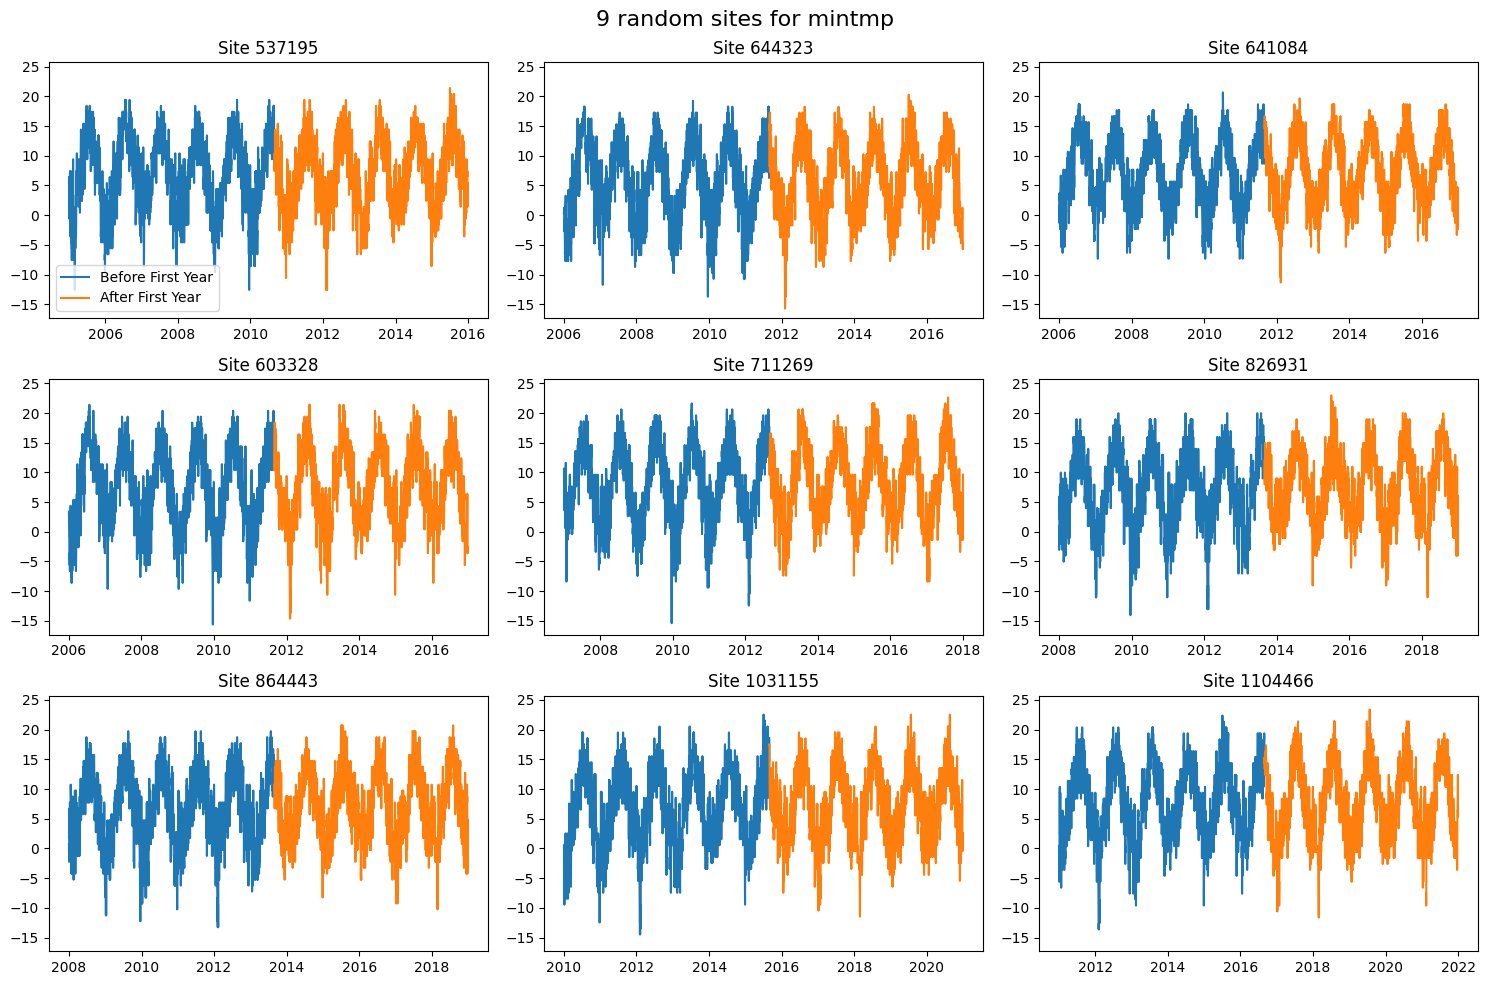

In [ ]:
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# Add a title to the entire grid
fig.suptitle(f"{len(axes.flatten())} random sites for {subfolder}", fontsize=16)

# Reduce df_unlisted to sites in random_sites
df_red = df_unlisted.query("idp in @random_sites").copy().reset_index(drop=True)

# If heatwave dataset, replace NA by 0 to make plot more readable
if subfolder == "heatw":
    df_red[subfolder] = df_red[subfolder].fillna(0)

# Get minimum and maximum value for y-axis
min_ = df_red[subfolder].min()
max_ = df_red[subfolder].max()

# Iterate over each subplot
for i, ax in enumerate(axes.flatten()):
    # Reduce df_unlisted to sites in random_sites
    random_site = df_red["idp"].unique()[i]

    # Get subset
    subset = df_red[df_red["idp"] == random_site]

    # Plot subset when before_first_year is true
    ax.plot(
        subset[subset["before_first_year"]]["date"],
        subset[subset["before_first_year"]][subfolder],
        label="Before First Year",
    )

    # Plot subset when before_first_year is false
    ax.plot(
        subset[~subset["before_first_year"]]["date"],
        subset[~subset["before_first_year"]][subfolder],
        label="After First Year",
    )

    ax.set_title(f"Site {random_site}")

    # Set y-axis limits
    ax.set_ylim((min_ + min_ * 0.1), (max_ + max_ * 0.1))

# Add legend to the last subplot
axes.flatten()[0].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Save the plot
if subset_of_coors:
    plotname = f"edo_qc_files/{subfolder}_random_sites_subset.png"
else:
    plotname = f"edo_qc_files/{subfolder}_random_sites.png"
plt.savefig(plotname)

# Show the plot
plt.show()

# Save File


In [ ]:
# Save pre-aggregation dataframe
if subset_of_coors:
    savedfeather = f"data_edo_{subfolder}_raw_subset.feather"
else:
    savedfeather = f"data_edo_{subfolder}_raw.feather"

df_unlisted.reset_index(drop=True).to_feather(savedfeather)

print(f"✅ Successfully saved dataframe:\t{savedfeather}\t at {datetime.datetime.now()}")
chime.success()

✅ Successfully saved dataframe:	data_edo_mintmp_raw.feather	 at 2023-12-11 19:29:29.935969
